In [106]:
#load all necessary libraries
import pandas as pd 
import numpy as np 
import scipy as scp
import seaborn as sns
import random
import sklearn
#import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

#df_test = pd.read_spss('data/newdata/مهندسی.sav')
df_test = pd.read_excel('data/data_w_origin/GHOMOYAT.xlsx')
print(df_test.shape)

(15363, 19)


In [107]:
import re
def remove_tags(string):
    result = re.sub('<.*?>','',string)
    return result

df_test['Sen']=df_test['Sen'].apply(lambda cw : remove_tags(cw))
#df_test.head()

def age_calc(string):
    year, month, day = string.split("/")
    year = 1401 - int(year)
    return year

df_test['Sen']=df_test['Sen'].apply(lambda cw : age_calc(cw))
df_test.head()

,Danshkadeh,Sen,Maghtah,Type,Moadel,Meliyat,Vaziyat Tahol,Farzandan,Sal,Komak Mali,Jensiyat,Eteghal,Enseraf,Hazf,Morakhasi,Tagher Reshteh,Mehman,Mantagheh,GDP
0,1,21,0,0,14.00,1,1,0,6,1,1,0,0,0,0,0,0,3,5
1,1,21,0,0,14.00,1,1,0,6,1,1,0,0,0,0,0,0,5,2
2,1,21,0,0,12.61,1,1,0,6,1,0,0,0,0,0,0,0,1,1
3,1,22,0,0,13.93,1,1,0,6,1,1,0,0,0,0,0,0,1,1
4,1,20,0,0,999.00,1,1,0,6,1,1,0,0,0,0,0,0,1,1


In [108]:
cols = ['Danshkadeh', 'Sen', 'Maghtah', 'Type', 'Moadel', 'Meliyat',
       'Vaziyat Tahol', 'Farzandan', 'Sal', 'Komak Mali', 'Jensiyat',
       'Eteghal', 'Enseraf', 'Hazf', 'Morakhasi', 'Tagher Reshteh', 'Mehman',
       'Mantagheh', 'GDP']
df_test.columns = cols
df_test.drop(['Mantagheh', 'GDP'], axis=1, inplace=True)
df_test.columns
df_test = df_test.loc[~(df_test == 999).any(axis=1)]

In [109]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13709 entries, 0 to 15362
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Danshkadeh      13709 non-null  int64  
 1   Sen             13709 non-null  int64  
 2   Maghtah         13709 non-null  int64  
 3   Type            13709 non-null  int64  
 4   Moadel          13709 non-null  float64
 5   Meliyat         13709 non-null  int64  
 6   Vaziyat Tahol   13709 non-null  int64  
 7   Farzandan       13709 non-null  int64  
 8   Sal             13709 non-null  int64  
 9   Komak Mali      13709 non-null  int64  
 10  Jensiyat        13709 non-null  int64  
 11  Eteghal         13709 non-null  int64  
 12  Enseraf         13709 non-null  int64  
 13  Hazf            13709 non-null  int64  
 14  Morakhasi       13709 non-null  int64  
 15  Tagher Reshteh  13709 non-null  int64  
 16  Mehman          13709 non-null  int64  
dtypes: float64(1), int64(16)
memory

## EDA

In [110]:
'''
# create a dictionary to map unique values to numbers
mapping_dict = {}
variables = list(set(df_test.columns) - {"ID", "Sen", "Moadel", "Farzandan", "Sal"})
for col in variables:
    unique_values = df_test[col].unique()
    mapping_dict[col] = {value: i for i, value in enumerate(unique_values)}

# replace values in data frame with mapped values
df_test.replace(mapping_dict, inplace=True)
df_test.head()
'''

'\n# create a dictionary to map unique values to numbers\nmapping_dict = {}\nvariables = list(set(df_test.columns) - {"ID", "Sen", "Moadel", "Farzandan", "Sal"})\nfor col in variables:\n    unique_values = df_test[col].unique()\n    mapping_dict[col] = {value: i for i, value in enumerate(unique_values)}\n\n# replace values in data frame with mapped values\ndf_test.replace(mapping_dict, inplace=True)\ndf_test.head()\n'

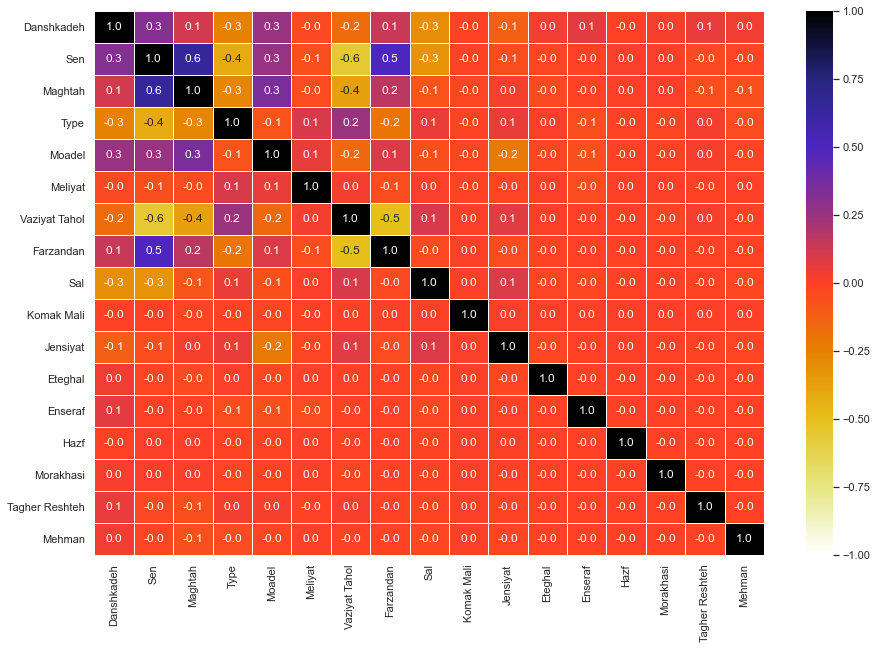

In [111]:
plt.figure(figsize=(15,10))
sns.heatmap(df_test.corr(), annot=True, linewidth=.5, vmin = -1, vmax = 1,cmap = plt.cm.CMRmap_r, fmt=".1f");

In [112]:
df_test.dropna(inplace=True)
df_test.isna().sum()

Danshkadeh        0
Sen               0
Maghtah           0
Type              0
Moadel            0
Meliyat           0
Vaziyat Tahol     0
Farzandan         0
Sal               0
Komak Mali        0
Jensiyat          0
Eteghal           0
Enseraf           0
Hazf              0
Morakhasi         0
Tagher Reshteh    0
Mehman            0
dtype: int64

## Model for GPA

In [113]:
df_test.head(1)

,Danshkadeh,Sen,Maghtah,Type,Moadel,Meliyat,Vaziyat Tahol,Farzandan,Sal,Komak Mali,Jensiyat,Eteghal,Enseraf,Hazf,Morakhasi,Tagher Reshteh,Mehman
0,1,21,0,0,14.0,1,1,0,6,1,1,0,0,0,0,0,0


<Axes: >

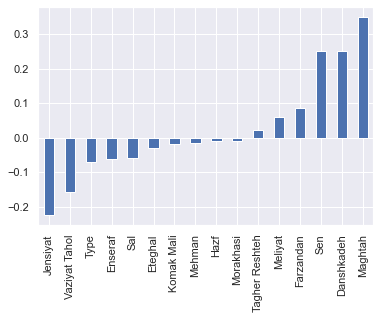

In [114]:
df_test.corr()['Moadel'].sort_values()[:-1].plot(kind='bar', grid=1)

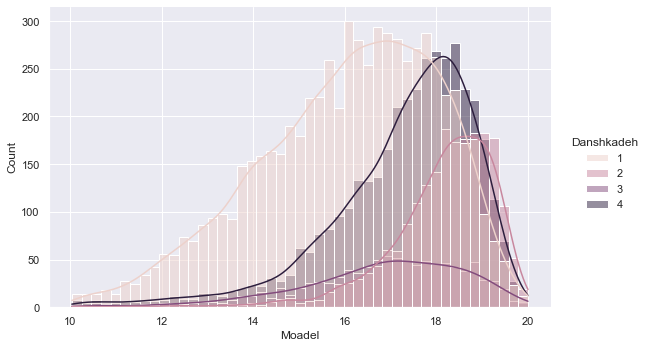

In [115]:
sns.displot(df_test, x= 'Moadel', hue=df_test['Danshkadeh'], kde=True, height=5, aspect=1.6)

<Axes: xlabel='Moadel', ylabel='Count'>

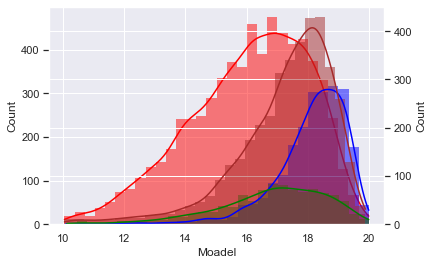

In [116]:
sns.set()
sns.histplot(df_test[df_test['Danshkadeh']==1]['Moadel'], bins=30, linewidth=0, kde=True, color='red')
ax2 = plt.twinx()
sns.histplot(df_test[df_test['Danshkadeh']==2]['Moadel'], bins=30, linewidth=0, kde=True, ax=ax2, color='blue')
sns.histplot(df_test[df_test['Danshkadeh']==3]['Moadel'], bins=30, linewidth=0, kde=True, ax=ax2, color='green')
sns.histplot(df_test[df_test['Danshkadeh']==4]['Moadel'], bins=30, linewidth=0, kde=True, ax=ax2, color='brown')

## Linear Regression

Columns for training: ['Danshkadeh', 'Sen', 'Maghtah', 'Type', 'Meliyat', 'Vaziyat Tahol', 'Farzandan', 'Sal', 'Komak Mali', 'Jensiyat', 'Eteghal', 'Enseraf', 'Hazf', 'Morakhasi', 'Tagher Reshteh', 'Mehman']


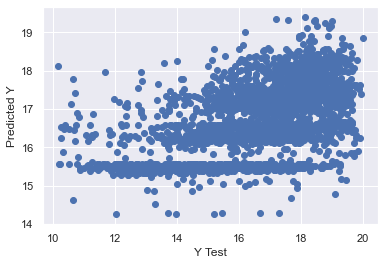

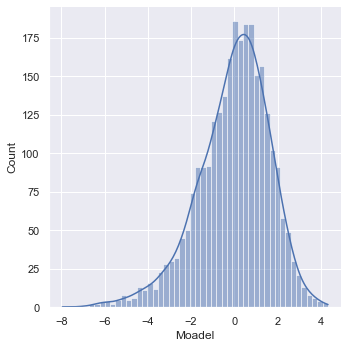

In [117]:
from sklearn.preprocessing import StandardScaler

X = df_test.drop(['Moadel'], axis=1) 
y = df_test['Moadel']
#y=y.astype('object')

print("Columns for training:", list(X.columns.values)) 

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.20, random_state = 5)
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train,y_train)

predictions = lm.predict(X_test)
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
#plt.plot(y_test,y_test,'r')
#plt.axis([10, 20, 12., 20])

sns.displot((y_test-predictions),bins=50, kde=True);

In [118]:
coeff_df = pd.DataFrame(lm.coef_,index=X.columns,columns=['Coefficient'])
#coeff_df

Variable: Maghtah              Importance: 0.691
Variable: Danshkadeh           Importance: 0.437
Variable: Type                 Importance: 0.142
Variable: Meliyat              Importance: 0.132
Variable: Sal                  Importance: 0.081
Variable: Tagher Reshteh       Importance: 0.048
Variable: Farzandan            Importance: 0.04
Variable: Vaziyat Tahol        Importance: 0.005
Variable: Mehman               Importance: -0.003
Variable: Komak Mali           Importance: -0.019
Variable: Hazf                 Importance: -0.021
Variable: Morakhasi            Importance: -0.023
Variable: Sen                  Importance: -0.035
Variable: Eteghal              Importance: -0.067
Variable: Enseraf              Importance: -0.121
Variable: Jensiyat             Importance: -0.375


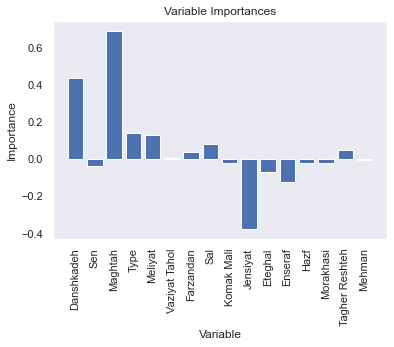

In [119]:
# Get numerical feature importances
feature_list = X.columns

importances = list(lm.coef_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
plt.grid()

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances'); 

In [120]:
coeff_df = pd.DataFrame(lm.coef_,index=X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
Danshkadeh,0.437485
Sen,-0.034893
Maghtah,0.690556
Type,0.141701
Meliyat,0.131767
Vaziyat Tahol,0.005397
Farzandan,0.040486
Sal,0.080883
Komak Mali,-0.018713
Jensiyat,-0.374582


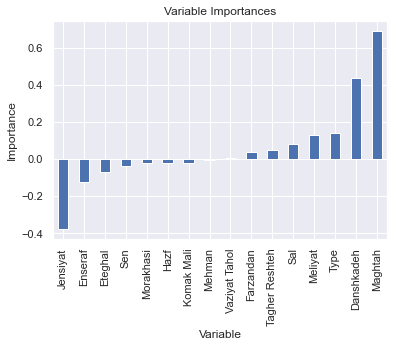

In [121]:
coeff_df['Coefficient'].sort_values()[:].plot(kind='bar', grid=1)
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances'); 

In [122]:
# calculate these metrics by hand!
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 1.2877228574443063
MSE: 2.776165926830711
RMSE: 1.6661830412144734


## NN for Regression

In [123]:
X_train.shape

(10967, 16)

In [124]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Dense(16,activation='relu'))
model.add(Dense(16,activation='relu'))
#model.add(Dense(11,activation='relu'))
model.add(Dense(1))

# early stopping callback
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')

model.compile(optimizer='adam',loss='mse')
model.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=10, verbose=False, callbacks=[early_stopping])

<Axes: >

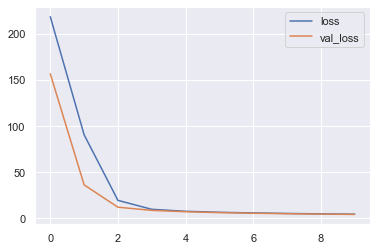

In [125]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [126]:
NN_pred = model.predict(X_test)
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

86/86 [==============================] - 0s 722us/step
MAE: 1.2877228574443063
MSE: 2.776165926830711
RMSE: 1.6661830412144734


86/86 [==============================] - 0s 2ms/step


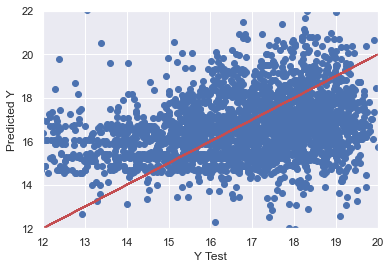

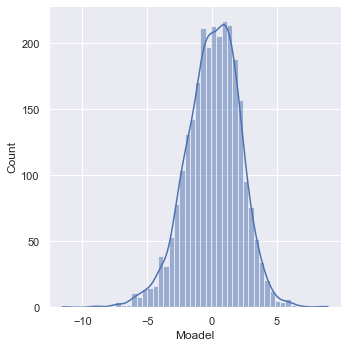

In [127]:
predictions = model.predict(X_test)
predictions = predictions.reshape(predictions.shape[0])
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.plot(y_test,y_test,'r')
plt.axis([12, 20, 12., 22])

sns.displot((y_test-predictions),bins=50, kde=True);

## Random Forest regressor

MAE: 1.2336858198390757
MSE: 2.581134777125345
RMSE: 1.6065910422772016


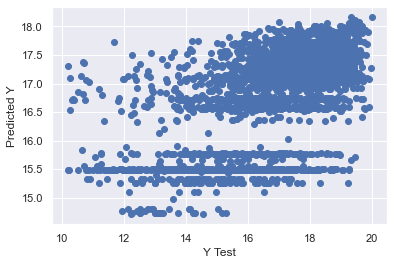

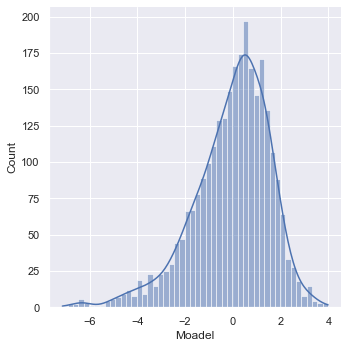

In [128]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 300, max_features = 'sqrt', max_depth = 5, random_state = 18).fit(X_train, y_train)

rf_predictions = rf.predict(X_test)
print('MAE:', metrics.mean_absolute_error(y_test, rf_predictions))
print('MSE:', metrics.mean_squared_error(y_test, rf_predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rf_predictions)))

rf_predictions = rf_predictions.reshape(predictions.shape[0])
plt.scatter(y_test,rf_predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
#plt.plot(y_test,y_test,'r')
#plt.axis([10, 20, 15., 18])

sns.displot((y_test-rf_predictions),bins=50, kde=True);


Variable: Danshkadeh           Importance: 0.354
Variable: Maghtah              Importance: 0.267
Variable: Sen                  Importance: 0.18
Variable: Jensiyat             Importance: 0.091
Variable: Sal                  Importance: 0.03
Variable: Vaziyat Tahol        Importance: 0.021
Variable: Type                 Importance: 0.016
Variable: Meliyat              Importance: 0.013
Variable: Enseraf              Importance: 0.011
Variable: Farzandan            Importance: 0.009
Variable: Eteghal              Importance: 0.003
Variable: Tagher Reshteh       Importance: 0.002
Variable: Hazf                 Importance: 0.001
Variable: Morakhasi            Importance: 0.001
Variable: Mehman               Importance: 0.001
Variable: Komak Mali           Importance: 0.0


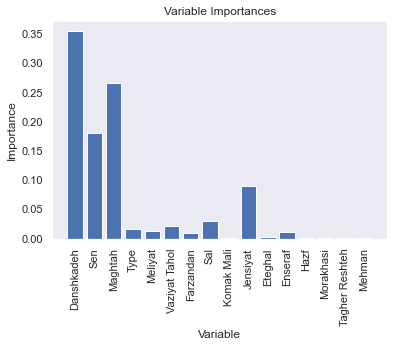

In [129]:
# Get numerical feature importances
feature_list = X.columns

importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
plt.grid()

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances'); 

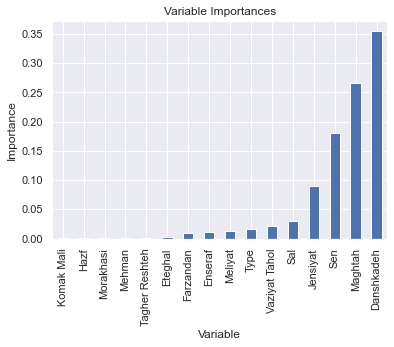

In [130]:
coeff_df_rf = pd.DataFrame(rf.feature_importances_,index=X.columns,columns=['Coefficient'])
coeff_df_rf['Coefficient'].sort_values()[:].plot(kind='bar', grid=1)
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances'); 

## Decision Tree Regresor

MAE: 1.274657192498844
MSE: 2.925784459597957
RMSE: 1.7104924611344994


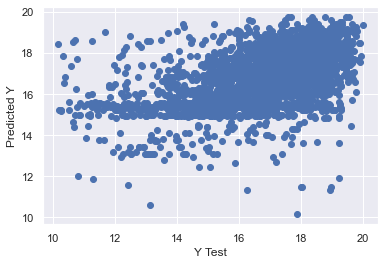

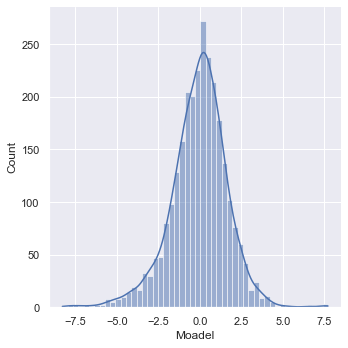

In [131]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(random_state = 18).fit(X_train, y_train)

dt_predictions = dt.predict(X_test)
print('MAE:', metrics.mean_absolute_error(y_test, dt_predictions))
print('MSE:', metrics.mean_squared_error(y_test, dt_predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, dt_predictions)))

dt_predictions = dt_predictions.reshape(predictions.shape[0])
plt.scatter(y_test,dt_predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
#plt.plot(y_test,y_test,'r')
#plt.axis([12, 20, 15., 18])

sns.displot((y_test-dt_predictions),bins=50, kde=True);


Variable: Danshkadeh           Importance: 0.319
Variable: Maghtah              Importance: 0.245
Variable: Sen                  Importance: 0.154
Variable: Sal                  Importance: 0.11
Variable: Type                 Importance: 0.031
Variable: Farzandan            Importance: 0.03
Variable: Jensiyat             Importance: 0.03
Variable: Meliyat              Importance: 0.022
Variable: Vaziyat Tahol        Importance: 0.022
Variable: Enseraf              Importance: 0.013
Variable: Eteghal              Importance: 0.007
Variable: Tagher Reshteh       Importance: 0.004
Variable: Mehman               Importance: 0.004
Variable: Hazf                 Importance: 0.003
Variable: Morakhasi            Importance: 0.003
Variable: Komak Mali           Importance: 0.002


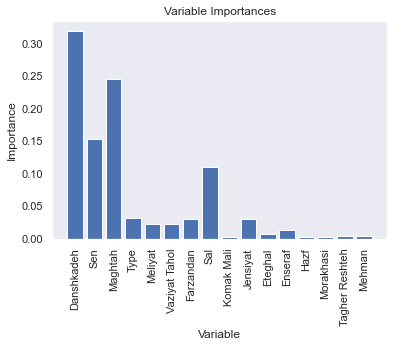

In [132]:

# Get numerical feature importances
feature_list = X.columns

importances = list(dt.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
plt.grid()

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances'); 

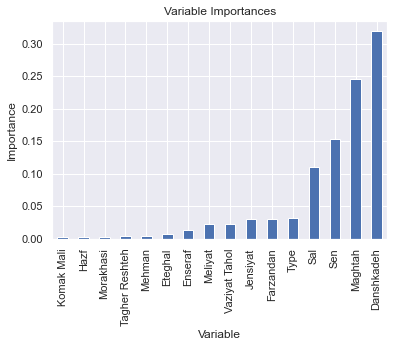

In [133]:
coeff_df_dt = pd.DataFrame(dt.feature_importances_,index=X.columns,columns=['Coefficient'])
coeff_df_dt['Coefficient'].sort_values()[:].plot(kind='bar', grid=1)
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances'); 

## Department exclusive

In [162]:
print(df_test['Danshkadeh'].value_counts())
faculty_recrod = np.sort(list(df_test['Danshkadeh'].unique()))
# df for all departments
faculty_df = [df_test[df_test['Danshkadeh'] == i] for i in faculty_recrod]

def train_NN(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(Dense(16,activation='relu'))
    model.add(Dense(16,activation='relu'))    
    model.add(Dense(1))

    # early stopping callback
    from keras.callbacks import EarlyStopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
    model.compile(optimizer='adam',loss='mse')
    model.fit(x=X_train,y=y_train.values,
            validation_data=(X_test,y_test.values),
            batch_size=128, epochs=20, verbose=False, callbacks=[early_stopping])
    def predictor(model):        
        NN_pred = model.predict(X_test)
        print('MAE:', metrics.mean_absolute_error(y_test, NN_pred))
        print('MSE:', metrics.mean_squared_error(y_test, NN_pred))
        print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, NN_pred)))
        print("---------------------------------\n")
    #predictor(model)  
    #NN_pred = model.predict(X_test)
    #mae = metrics.mean_absolute_error(y_test, NN_pred)
    #mse = metrics.mean_squared_error(y_test, NN_pred)
    #rmse =   np.sqrt(mse)
    #return model, mae, mse, rmse
    return model

model_list = []
for df in faculty_df:
    print("Department class:", df['Danshkadeh'].unique())
    X = df.drop(['Moadel'], axis=1) 
    y = df['Moadel']    
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.20, random_state = 5)
    scaler = StandardScaler()
    X_train= scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    model_list.append(train_NN(X_train, y_train, X_test, y_test))

1    6713
4    3918
2    2089
3     989
Name: Danshkadeh, dtype: int64
Department class: [1]
Department class: [2]
Department class: [3]
Department class: [4]


In [160]:
model_list

[(<keras.engine.sequential.Sequential at 0x7f9be2dad1c0>,
  1.6532554740792145,
  4.640341284666247,
  2.154145140111559),
 (<keras.engine.sequential.Sequential at 0x7f9c03860490>,
  3.2421408933429623,
  15.924685085716174,
  3.9905745307807714),
 (<keras.engine.sequential.Sequential at 0x7f9bf3ff0f10>,
  7.955107239520912,
  72.61851881395151,
  8.521650005365833),
 (<keras.engine.sequential.Sequential at 0x7f9bf5264b50>,
  1.6985712556449735,
  4.68817795396485,
  2.165220070562078)]

<Axes: >

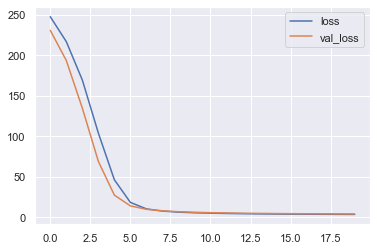

In [163]:
losses = pd.DataFrame(model_list[0].history.history)
losses.plot()

<Axes: >

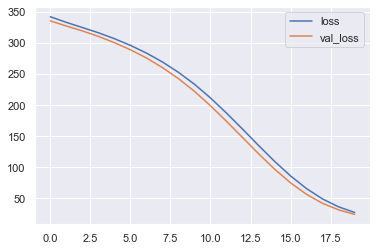

In [149]:
losses = pd.DataFrame(model_list[1].history.history)
losses.plot()

<Axes: >

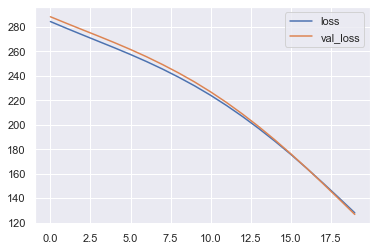

In [150]:
losses = pd.DataFrame(model_list[2].history.history)
losses.plot()

<Axes: >

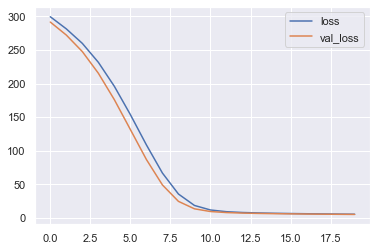

In [151]:
losses = pd.DataFrame(model_list[3].history.history)
losses.plot()